In [5]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc['reso']='xx-hi'
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

In [6]:
CONFIGSPATH = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/src/pod/configs.json'
with open(CONFIGSPATH,'r',encoding='utf-8') as f:
    CONFIGS = json.load(f)

FILEDIR    = CONFIGS['paths']['filedir']      
MODELDIR   = CONFIGS['paths']['modeldir']    
RESULTSDIR = CONFIGS['paths']['resultsdir']  
RUNS       = CONFIGS['runs']
SPLIT      = 'valid'
PRTHRESH   = 0.01

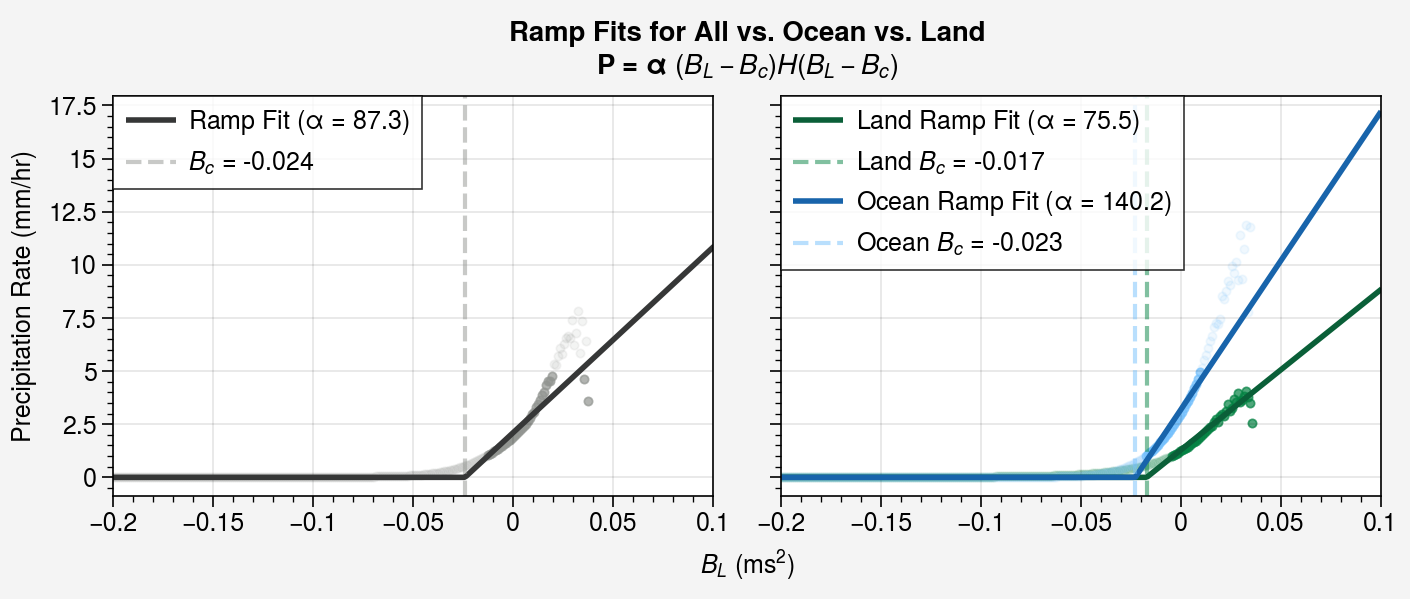

In [50]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=3,refheight=2,share=True)
axs.format(suptitle='Ramp Fits for All vs. Ocean vs. Land\nP = $\\alpha$ $\mathit{(B_L - B_c) H (B_L - B_c)}$',
           xlabel='$\mathit{B_L}$ (ms$^2$)',xlim=(-0.2,0.1),ylabel='Precipitation Rate (mm/hr)')

for i,run in enumerate(RUNS):
    runname     = run['run_name']
    mode        = run['mode']
    description = run['description']
    data  = np.load(f'{MODELDIR}/pod_{runname}.npz')
    xbins = data['bincenters']
    if mode=='pooled':
        ymeans   = data['ymeanpooled']
        fitrange = data['fitrangepooled']
        alpha    = float(data['alphapooled'])
        blcrit   = float(data['blcritpooled'])
        axs[i].scatter(xbins[~fitrange],ymeans[~fitrange],color='gray',marker='.',alpha=0.1)
        axs[i].scatter(xbins[fitrange],ymeans[fitrange],color='gray',marker='.',alpha=0.7)
        axs[i].plot(xbins,alpha*np.maximum(0,xbins-blcrit),color='dark gray',linewidth=2,label=f'Ramp Fit ($\\alpha$ = {alpha:.1f})')
        axs[i].axvline(blcrit,color='gray',alpha=0.5,linestyle='--',label=fr'$\mathit{{B_c}}$ = {blcrit:.3f}')
    elif mode == 'regional':
        ymeansland    = data['ymeanland']
        fitrangeland  = data['fitrangeland']
        alphaland     = float(data['alphaland'])
        blcritland    = float(data['blcritland'])
        ymeansocean   = data['ymeanocean']
        fitrangeocean = data['fitrangeocean']
        alphaocean    = float(data['alphaocean'])
        blcritocean   = float(data['blcritocean'])
        axs[i].scatter(xbins[~fitrangeland],ymeansland[~fitrangeland],color='jungle green',marker='.',alpha=0.1)
        axs[i].scatter(xbins[fitrangeland],ymeansland[fitrangeland],color='jungle green',marker='.',alpha=0.7)
        axs[i].plot(xbins,alphaland*np.maximum(0,xbins-blcritland),color='spruce',linewidth=2,label=f'Land Ramp Fit ($\\alpha$ = {alphaland:.1f})')
        axs[i].axvline(blcritland,color='jungle green',alpha=0.5,linestyle='--',label=fr'Land $\mathit{{B_c}}$ = {blcritland:.3f}')
        axs[i].scatter(xbins[~fitrangeocean],ymeansocean[~fitrangeocean],color='blue3',marker='.',alpha=0.1)
        axs[i].scatter(xbins[fitrangeocean],ymeansocean[fitrangeocean],color='blue3',marker='.',alpha=0.7)
        axs[i].plot(xbins,alphaocean*np.maximum(0,xbins-blcritocean),color='blue9',linewidth=2,label=f'Ocean Ramp Fit ($\\alpha$ = {alphaocean:.1f})')
        axs[i].axvline(blcritocean,color='blue3',alpha=0.5,linestyle='--',label=fr'Ocean $\mathit{{B_c}}$ = {blcritocean:.3f}')

axs.legend(loc='ul',ncols=1)
pplt.show()

In [69]:
def get_r2(ytrue,ypred,dims=None,fillnan=None):
    if fillnan is None:
        ypred = ypred
    elif fillnan=='mean':
        ypred = ypred.fillna(float(ytrue.mean(skipna=True)))
    else:
        ypred = ypred.fillna(float(fillnan))
    if dims is None:
        dims = list(ytrue.dims)
    mu  = ytrue.mean(dim=dims,skipna=True)
    rss = ((ypred-ytrue)**2).sum(dim=dims,skipna=True)
    tss = ((ytrue-mu)**2).sum(dim=dims,skipna=True)
    r2  = 1.0- (rss/tss)
    return float(r2) if not r2.dims else r2

def get_mcc(ytrue,ypred,dims=None,nanasnone=True,prthresh=PRTHRESH):
    if dims is None:
        dims = list(ytrue.dims)
    ytrueabove = ytrue>prthresh
    ypredabove = ypred>prthresh
    if nanasnone:
        ypredabove = ypredabove.fillna(False)
    tp = (ypredabove&ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    tn = (~ypredabove&~ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    fp = (ypredabove&~ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    fn = (~ypredabove&ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    numerator   = tp*tn-fp*fn
    denominator = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    mcc = xr.where(denominator==0,0.0,numerator/denominator)
    if not mcc.dims:
        return float(mcc),int(tp),int(fp),int(fn),int(tn)
    return mcc,tp.astype('int64'),fp.astype('int64'),fn.astype('int64'),tn.astype('int64')

In [70]:
truepath = os.path.join(FILEDIR,f'{SPLIT}.h5')
with xr.open_dataset(truepath,engine='h5netcdf') as ds:
    truepr = ds['pr'].load()

results = {}
for run in RUNS:
    runname     = run['run_name']
    description = run.get('description',runname)
    predpath    = os.path.join(RESULTSDIR,f'pod_{runname}_{SPLIT}_pr.nc')
    with xr.open_dataset(predpath,engine='h5netcdf') as ds:
        predpr = ds['pr'].load()
    ytrue,ypred= xr.align(truepr,predpr,join='inner')
    results[runname] = dict(description=description,ytrue=ytrue,ypred=ypred)

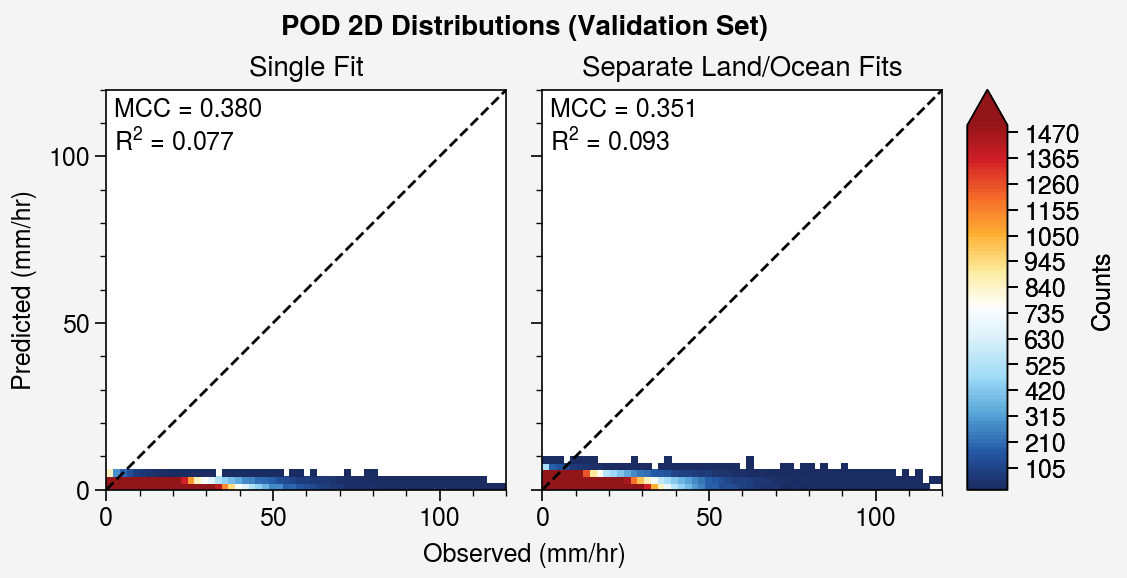

In [71]:
globalmin = 0
globalmax = 120
binedges  = np.linspace(globalmin,globalmax,60)

paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrue = result['ytrue']
    ypred = result['ypred']
    r2     = get_r2(ytrue,ypred,dims=None,fillnan='mean')
    mcc,*_ = get_mcc(ytrue,ypred,dims=None,nanasnone=True)
    ytrueflat = ytrue.values.ravel()
    ypredflat = ypred.values.ravel()
    finite = np.isfinite(ytrueflat)&np.isfinite(ypredflat)
    hist,_,_ = np.histogram2d(ytrueflat[finite],ypredflat[finite],bins=[binedges,binedges])
    hist = np.ma.masked_where(hist==0,hist)
    paneldata.append((description,hist,float(r2),float(mcc)))

fig,axs = pplt.subplots(nrows=1,ncols=len(paneldata),refwidth=2,share=True)
axs.format(suptitle='POD 2D Distributions (Validation Set)',xlabel='Observed (mm/hr)',ylabel='Predicted (mm/hr)')

im = None
for ax,(description,hist,r2,mcc) in zip(axs,paneldata):
    im = ax.pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',vmin=1,vmax=1500,levels=100,extend='max')
    ax.plot([globalmin,globalmax],[globalmin,globalmax],color='k',linewidth=1,linestyle='--')
    ax.text(0.02,0.98,f'MCC = {mcc:.3f}\nR$^2$ = {r2:.3f}',transform=ax.transAxes,va='top',ha='left')
    ax.format(title=description,xlim=(globalmin,globalmax),xticks=50,ylim=(globalmin,globalmax),yticks=50)

fig.colorbar(im,loc='r',label='Counts')
pplt.show()

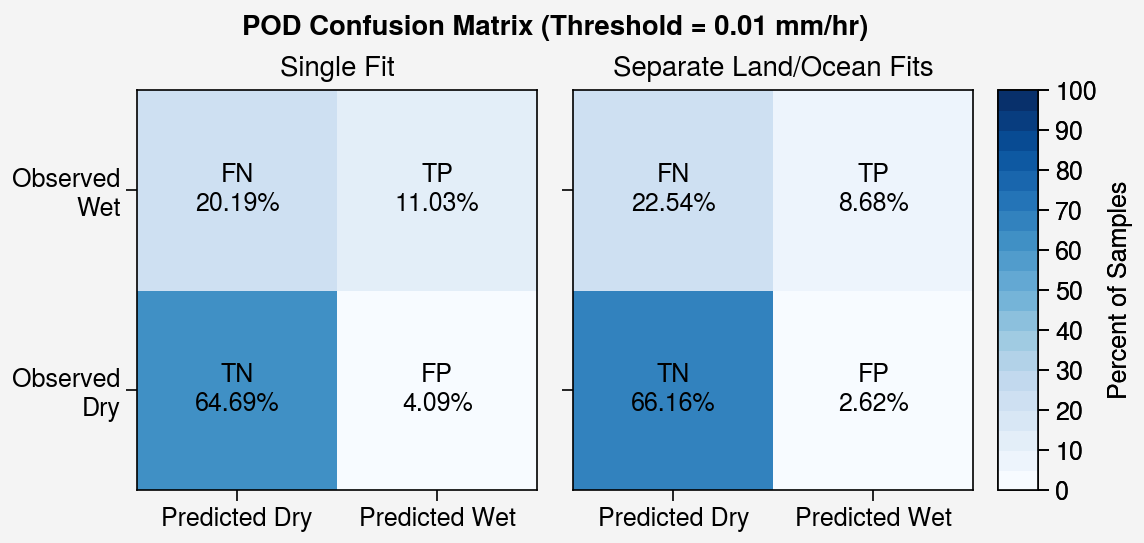

In [72]:
paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrue  = result['ytrue']
    ypred  = result['ypred']
    finite = np.isfinite(ytrueflat)&np.isfinite(ypredflat)
    mcc,tp,fp,fn,tn = get_mcc(ytrue,ypred,dims=None,nanasnone=True)
    total  = tp+fp+tn+fn
    matrix = 100.0*np.array([[tn,fp],[fn,tp]],dtype=float)/total
    paneldata.append((description,matrix,dict(TP=tp,FP=fp,FN=fn,TN=tn,total=total)))

fig,axs = pplt.subplots(ncols=len(paneldata),refwidth=2,share=True)
axs.format(suptitle=f'POD Confusion Matrix (Threshold = {PRTHRESH} mm/hr)')
im = None
for ax,(description,matrix,count) in zip(axs,paneldata):
    xedges = [0,1,2]
    yedges = [0,1,2]
    im = ax.pcolormesh(xedges,yedges,matrix,cmap='Blues',vmin=0,vmax=100,levels=21)
    labels = [
        ('TN',count['TN'],matrix[0,0],0.5,0.5),
        ('FP',count['FP'],matrix[0,1],1.5,0.5), 
        ('FN',count['FN'],matrix[1,0],0.5,1.5), 
        ('TP',count['TP'],matrix[1,1],1.5,1.5)]
    for label,value,percent,x,y in labels:
        ax.text(x,y,f'{label}\n{percent:.2f}%',ha='center',va='center')
    ax.format(title=description,
              xlim=(0,2),xticks=[0.5,1.5],xticklabels=['Predicted Dry','Predicted Wet'],xminorticks='none',
              ylim=(0,2),yticks=[0.5,1.5],yticklabels=['Observed\nDry','Observed\nWet'],yminorticks='none')
fig.colorbar(im,loc='r',label='Percent of Samples')
pplt.show()

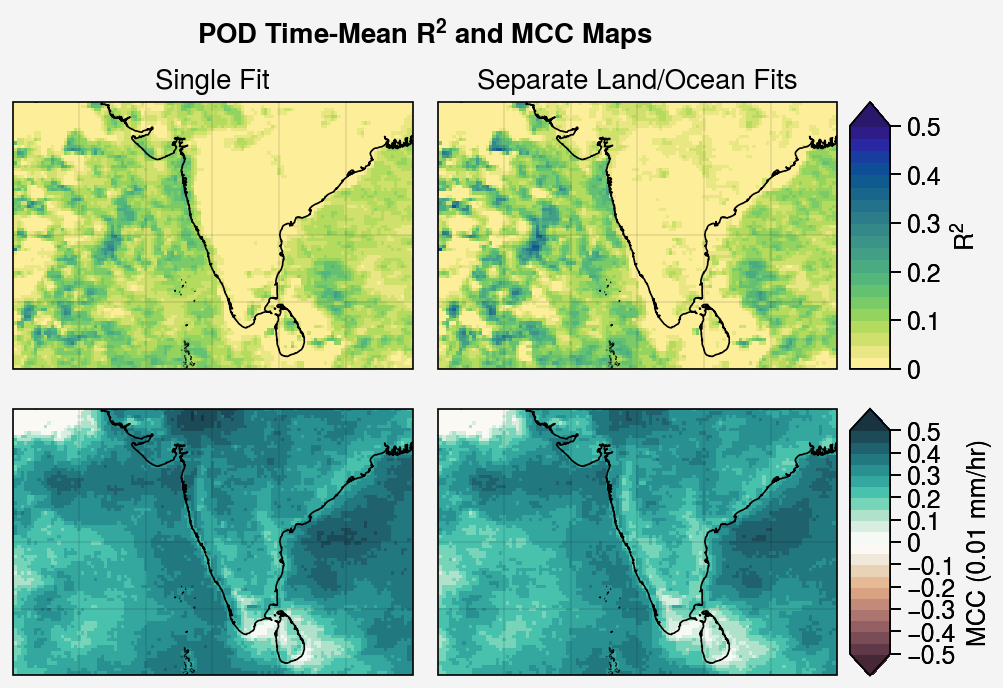

In [73]:
paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrue = result['ytrue']
    ypred = result['ypred']
    r2     = get_r2(ytrue,ypred,dims=['time'],fillnan=None)
    mcc,*_ = get_mcc(ytrue,ypred,dims=['time'],nanasnone=True)
    paneldata.append((description,r2,mcc))

fig,axs = pplt.subplots(nrows=2,ncols=len(paneldata),refwidth=2,proj='cyl',share=False)
axs.format(suptitle=f'POD Time-Mean R$^2$ and MCC Maps',
           coast=True,latlim=(5.,25.),latlines=[5,10,15],lonlim=(60.,90.),lonlines=5)

im1,im2 = None,None
for col,(description,r2,mcc) in enumerate(paneldata):
    im1 = axs[0,col].pcolormesh(r2.lon,r2.lat,r2,cmap='Haline_r',vmin=0,vmax=0.5,levels=20,extend='max')
    im2 = axs[1,col].pcolormesh(mcc.lon,mcc.lat,mcc,cmap='DryWet',vmin=-0.5,vmax=0.5,levels=20,extend='both')
    axs[0,col].format(title=description)
axs[1].colorbar(im1,loc='r',label='R$^2$',ticks=0.1)
axs[-1].colorbar(im2,loc='r',label=f'MCC ({PRTHRESH} mm/hr)',ticks=0.1)
pplt.show()